# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

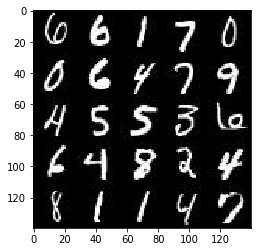

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

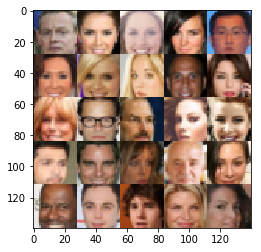

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr", shape=())

    return inputs_real, inputs_z, learning_rate
  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False,alpha=.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
        
        conv3 = tf.layers.conv2d(conv2, 256, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob)
        
        #conv4 = tf.layers.conv2d(conv3, 512, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        #conv4 = tf.layers.batch_normalization(conv4, training=True)
        #conv4 = tf.maximum(alpha * conv4, conv4)
        #conv4 = tf.nn.dropout(conv3, keep_prob=keep_prob)
           
        
        flat = tf.reshape(conv3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, alpha=.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        fullyc1 = tf.layers.dense(z, 7*7*512)
        fullyc1 = tf.reshape(fullyc1, (-1, 7, 7, 512))
        fullyc1 = tf.layers.batch_normalization(fullyc1, training=is_train)
        fullyc1 = tf.maximum(alpha * fullyc1, fullyc1)
     
        
        gl2 = tf.layers.conv2d_transpose(fullyc1, 256, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        gl2 = tf.layers.batch_normalization(gl2, training=is_train)
        gl2 = tf.maximum(alpha * gl2, gl2)
        gl2 = tf.nn.dropout(gl2, keep_prob=keep_prob)
       
        
        gl3 = tf.layers.conv2d_transpose(gl2, 128, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        gl3 = tf.layers.batch_normalization(gl3, training=is_train)
        gl3 = tf.maximum(alpha * gl3, gl3)   
        gl3 = tf.nn.dropout(gl3, keep_prob=keep_prob)
       
        #gl4 = tf.layers.conv2d_transpose(gl3, 32, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        #gl4 = tf.layers.batch_normalization(gl4, training=is_train)
        #gl4 = tf.maximum(alpha * gl4, gl4)   
        #gl4 = tf.nn.dropout(gl4, keep_prob=keep_prob)     
      
        logits = tf.layers.conv2d_transpose(gl3, out_channel_dim, 3, strides=1, padding='same', activation=None)
    
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real,
            labels = tf.ones_like(d_output_real) * .9
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.zeros_like(d_output_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.ones_like(d_output_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

        return d_train_opt, g_train_opt







"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    steps = 0
    losses = []
    show_every = 100
    print_every = 10
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                if steps % print_every == 0:
                
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
               
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


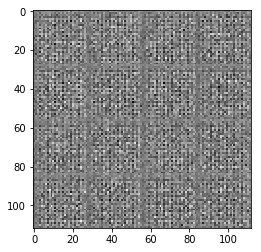

Epoch 1/2... Generator Loss: 2.0987 Discriminator Loss: 0.6040...
Epoch 1/2... Generator Loss: 4.7800 Discriminator Loss: 0.3652...
Epoch 1/2... Generator Loss: 4.3329 Discriminator Loss: 0.3807...
Epoch 1/2... Generator Loss: 4.1325 Discriminator Loss: 0.7818...
Epoch 1/2... Generator Loss: 5.6981 Discriminator Loss: 0.3500...
Epoch 1/2... Generator Loss: 0.1666 Discriminator Loss: 2.7251...
Epoch 1/2... Generator Loss: 1.1250 Discriminator Loss: 1.1081...
Epoch 1/2... Generator Loss: 2.5764 Discriminator Loss: 0.9536...
Epoch 1/2... Generator Loss: 1.5736 Discriminator Loss: 0.7989...
Epoch 1/2... Generator Loss: 1.4240 Discriminator Loss: 0.8275...


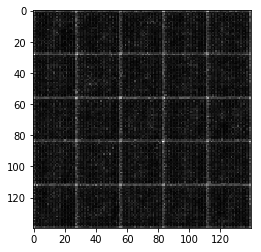

Epoch 1/2... Generator Loss: 2.1589 Discriminator Loss: 0.8239...
Epoch 1/2... Generator Loss: 1.5692 Discriminator Loss: 0.9895...
Epoch 1/2... Generator Loss: 1.1264 Discriminator Loss: 0.9841...
Epoch 1/2... Generator Loss: 2.2458 Discriminator Loss: 1.0439...
Epoch 1/2... Generator Loss: 1.6670 Discriminator Loss: 1.0158...
Epoch 1/2... Generator Loss: 1.3521 Discriminator Loss: 0.9767...
Epoch 1/2... Generator Loss: 0.6355 Discriminator Loss: 1.2645...
Epoch 1/2... Generator Loss: 1.3858 Discriminator Loss: 0.8854...
Epoch 1/2... Generator Loss: 2.9504 Discriminator Loss: 1.3336...
Epoch 1/2... Generator Loss: 0.8150 Discriminator Loss: 1.1472...


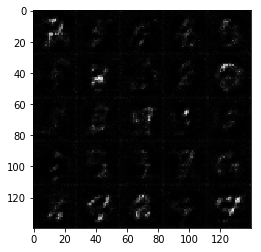

Epoch 1/2... Generator Loss: 1.8129 Discriminator Loss: 0.9314...
Epoch 1/2... Generator Loss: 1.6304 Discriminator Loss: 0.9198...
Epoch 1/2... Generator Loss: 0.8089 Discriminator Loss: 1.1315...
Epoch 1/2... Generator Loss: 2.0913 Discriminator Loss: 0.8580...
Epoch 1/2... Generator Loss: 1.3858 Discriminator Loss: 0.8290...
Epoch 1/2... Generator Loss: 0.7595 Discriminator Loss: 1.2069...
Epoch 1/2... Generator Loss: 2.0121 Discriminator Loss: 0.8859...
Epoch 1/2... Generator Loss: 1.3518 Discriminator Loss: 0.7615...
Epoch 1/2... Generator Loss: 1.7005 Discriminator Loss: 0.8658...
Epoch 1/2... Generator Loss: 1.9726 Discriminator Loss: 0.9065...


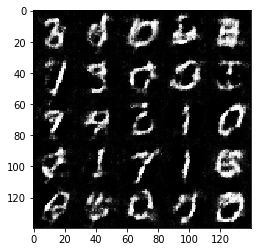

Epoch 1/2... Generator Loss: 1.4955 Discriminator Loss: 0.8478...
Epoch 1/2... Generator Loss: 1.4017 Discriminator Loss: 0.9081...
Epoch 1/2... Generator Loss: 2.7377 Discriminator Loss: 1.3356...
Epoch 1/2... Generator Loss: 1.5475 Discriminator Loss: 1.0108...
Epoch 1/2... Generator Loss: 1.1735 Discriminator Loss: 0.9265...
Epoch 1/2... Generator Loss: 1.7832 Discriminator Loss: 0.9232...
Epoch 1/2... Generator Loss: 1.6460 Discriminator Loss: 0.9997...
Epoch 1/2... Generator Loss: 1.4385 Discriminator Loss: 0.8509...
Epoch 1/2... Generator Loss: 2.2538 Discriminator Loss: 1.2069...
Epoch 1/2... Generator Loss: 1.7198 Discriminator Loss: 0.9678...


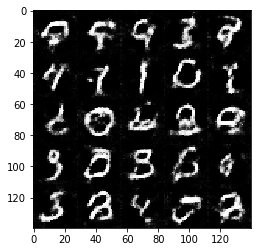

Epoch 1/2... Generator Loss: 1.6774 Discriminator Loss: 0.9558...
Epoch 1/2... Generator Loss: 1.7479 Discriminator Loss: 0.9960...
Epoch 1/2... Generator Loss: 2.3566 Discriminator Loss: 1.1487...
Epoch 1/2... Generator Loss: 2.4476 Discriminator Loss: 1.1380...
Epoch 1/2... Generator Loss: 0.8438 Discriminator Loss: 1.0812...
Epoch 1/2... Generator Loss: 0.6210 Discriminator Loss: 1.2645...
Epoch 2/2... Generator Loss: 1.3175 Discriminator Loss: 0.9577...
Epoch 2/2... Generator Loss: 1.6897 Discriminator Loss: 1.0156...
Epoch 2/2... Generator Loss: 0.9871 Discriminator Loss: 1.0310...
Epoch 2/2... Generator Loss: 1.5129 Discriminator Loss: 1.1094...


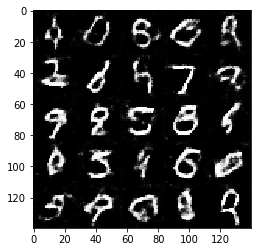

Epoch 2/2... Generator Loss: 0.6245 Discriminator Loss: 1.2917...
Epoch 2/2... Generator Loss: 1.9521 Discriminator Loss: 0.9524...
Epoch 2/2... Generator Loss: 1.4564 Discriminator Loss: 0.9558...
Epoch 2/2... Generator Loss: 0.4982 Discriminator Loss: 1.5420...
Epoch 2/2... Generator Loss: 1.0231 Discriminator Loss: 1.0045...
Epoch 2/2... Generator Loss: 1.2544 Discriminator Loss: 0.9736...
Epoch 2/2... Generator Loss: 1.2187 Discriminator Loss: 0.9855...
Epoch 2/2... Generator Loss: 1.0127 Discriminator Loss: 0.9784...
Epoch 2/2... Generator Loss: 0.9451 Discriminator Loss: 1.0552...
Epoch 2/2... Generator Loss: 1.4818 Discriminator Loss: 0.9671...


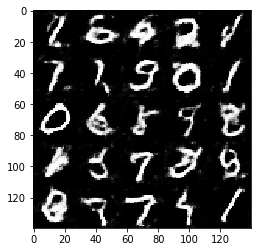

Epoch 2/2... Generator Loss: 1.6520 Discriminator Loss: 1.0048...
Epoch 2/2... Generator Loss: 0.6889 Discriminator Loss: 1.2501...
Epoch 2/2... Generator Loss: 1.0349 Discriminator Loss: 1.0030...
Epoch 2/2... Generator Loss: 1.7491 Discriminator Loss: 1.0097...
Epoch 2/2... Generator Loss: 1.3881 Discriminator Loss: 1.0156...
Epoch 2/2... Generator Loss: 0.7921 Discriminator Loss: 1.1301...
Epoch 2/2... Generator Loss: 0.7880 Discriminator Loss: 1.1331...
Epoch 2/2... Generator Loss: 0.9651 Discriminator Loss: 0.9888...
Epoch 2/2... Generator Loss: 1.4899 Discriminator Loss: 0.8709...
Epoch 2/2... Generator Loss: 2.5732 Discriminator Loss: 1.4377...


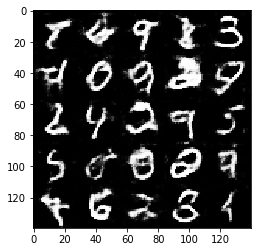

Epoch 2/2... Generator Loss: 1.1824 Discriminator Loss: 1.0145...
Epoch 2/2... Generator Loss: 1.5516 Discriminator Loss: 0.9709...
Epoch 2/2... Generator Loss: 0.9964 Discriminator Loss: 0.9931...
Epoch 2/2... Generator Loss: 1.4062 Discriminator Loss: 0.9329...
Epoch 2/2... Generator Loss: 1.2812 Discriminator Loss: 1.0284...
Epoch 2/2... Generator Loss: 0.4874 Discriminator Loss: 1.5064...
Epoch 2/2... Generator Loss: 1.2517 Discriminator Loss: 0.9121...
Epoch 2/2... Generator Loss: 1.5792 Discriminator Loss: 0.9405...
Epoch 2/2... Generator Loss: 1.3012 Discriminator Loss: 0.9312...
Epoch 2/2... Generator Loss: 0.8603 Discriminator Loss: 1.0309...


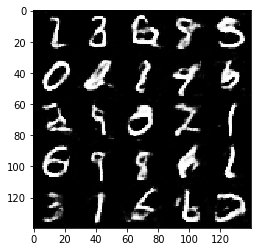

Epoch 2/2... Generator Loss: 0.7840 Discriminator Loss: 1.1527...
Epoch 2/2... Generator Loss: 1.0664 Discriminator Loss: 1.0162...
Epoch 2/2... Generator Loss: 0.8625 Discriminator Loss: 1.0146...
Epoch 2/2... Generator Loss: 1.6505 Discriminator Loss: 0.9920...
Epoch 2/2... Generator Loss: 1.5267 Discriminator Loss: 0.9834...
Epoch 2/2... Generator Loss: 1.8821 Discriminator Loss: 0.9207...
Epoch 2/2... Generator Loss: 1.7477 Discriminator Loss: 1.0000...
Epoch 2/2... Generator Loss: 1.4200 Discriminator Loss: 0.9547...
Epoch 2/2... Generator Loss: 2.1972 Discriminator Loss: 1.1462...
Epoch 2/2... Generator Loss: 0.8542 Discriminator Loss: 1.0642...


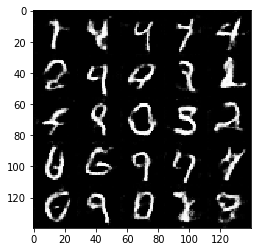

Epoch 2/2... Generator Loss: 1.0695 Discriminator Loss: 0.8913...
Epoch 2/2... Generator Loss: 1.4846 Discriminator Loss: 0.8402...
Epoch 2/2... Generator Loss: 1.3754 Discriminator Loss: 0.9212...


In [22]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


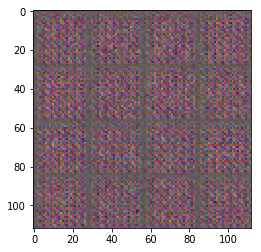

Epoch 1/1... Generator Loss: 3.0654 Discriminator Loss: 0.4688...
Epoch 1/1... Generator Loss: 3.8317 Discriminator Loss: 0.5545...
Epoch 1/1... Generator Loss: 1.5983 Discriminator Loss: 0.7798...
Epoch 1/1... Generator Loss: 4.6159 Discriminator Loss: 1.3312...
Epoch 1/1... Generator Loss: 0.8996 Discriminator Loss: 1.1146...
Epoch 1/1... Generator Loss: 1.6992 Discriminator Loss: 0.6117...
Epoch 1/1... Generator Loss: 3.3020 Discriminator Loss: 0.5503...
Epoch 1/1... Generator Loss: 1.8233 Discriminator Loss: 0.6153...
Epoch 1/1... Generator Loss: 2.1915 Discriminator Loss: 0.5393...
Epoch 1/1... Generator Loss: 2.1560 Discriminator Loss: 0.6274...


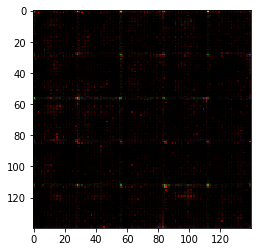

Epoch 1/1... Generator Loss: 2.4361 Discriminator Loss: 0.7609...
Epoch 1/1... Generator Loss: 1.2071 Discriminator Loss: 0.9220...
Epoch 1/1... Generator Loss: 0.8346 Discriminator Loss: 1.2156...
Epoch 1/1... Generator Loss: 1.6626 Discriminator Loss: 0.8035...
Epoch 1/1... Generator Loss: 0.9063 Discriminator Loss: 0.9774...
Epoch 1/1... Generator Loss: 1.2607 Discriminator Loss: 0.9165...
Epoch 1/1... Generator Loss: 1.0128 Discriminator Loss: 1.1300...
Epoch 1/1... Generator Loss: 1.1859 Discriminator Loss: 0.8912...
Epoch 1/1... Generator Loss: 0.8004 Discriminator Loss: 1.1887...
Epoch 1/1... Generator Loss: 2.0206 Discriminator Loss: 1.1040...


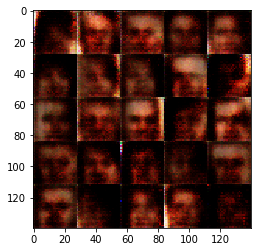

Epoch 1/1... Generator Loss: 2.7138 Discriminator Loss: 0.7425...
Epoch 1/1... Generator Loss: 2.1618 Discriminator Loss: 1.0211...
Epoch 1/1... Generator Loss: 0.9134 Discriminator Loss: 1.1278...
Epoch 1/1... Generator Loss: 0.4088 Discriminator Loss: 1.5314...
Epoch 1/1... Generator Loss: 2.4417 Discriminator Loss: 1.3192...
Epoch 1/1... Generator Loss: 0.7489 Discriminator Loss: 1.3111...
Epoch 1/1... Generator Loss: 0.7692 Discriminator Loss: 1.1504...
Epoch 1/1... Generator Loss: 0.4611 Discriminator Loss: 1.5907...
Epoch 1/1... Generator Loss: 2.5557 Discriminator Loss: 1.0662...
Epoch 1/1... Generator Loss: 1.1056 Discriminator Loss: 1.0624...


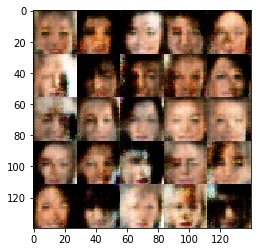

Epoch 1/1... Generator Loss: 1.4033 Discriminator Loss: 0.9116...
Epoch 1/1... Generator Loss: 1.1550 Discriminator Loss: 1.1227...
Epoch 1/1... Generator Loss: 0.5941 Discriminator Loss: 1.3510...
Epoch 1/1... Generator Loss: 2.9127 Discriminator Loss: 1.4989...
Epoch 1/1... Generator Loss: 1.6295 Discriminator Loss: 1.1409...
Epoch 1/1... Generator Loss: 4.6757 Discriminator Loss: 2.8491...
Epoch 1/1... Generator Loss: 1.2789 Discriminator Loss: 1.1115...
Epoch 1/1... Generator Loss: 0.6087 Discriminator Loss: 1.2805...
Epoch 1/1... Generator Loss: 0.7547 Discriminator Loss: 1.1793...
Epoch 1/1... Generator Loss: 0.9575 Discriminator Loss: 1.0166...


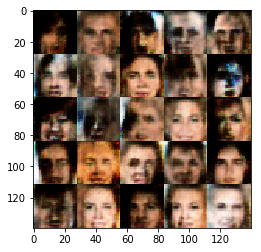

Epoch 1/1... Generator Loss: 1.0837 Discriminator Loss: 1.0602...
Epoch 1/1... Generator Loss: 3.1657 Discriminator Loss: 2.1161...
Epoch 1/1... Generator Loss: 0.9598 Discriminator Loss: 1.0636...
Epoch 1/1... Generator Loss: 1.4437 Discriminator Loss: 1.1169...
Epoch 1/1... Generator Loss: 0.8905 Discriminator Loss: 1.1181...
Epoch 1/1... Generator Loss: 0.6834 Discriminator Loss: 1.2179...
Epoch 1/1... Generator Loss: 1.2501 Discriminator Loss: 1.1218...
Epoch 1/1... Generator Loss: 0.7105 Discriminator Loss: 1.2889...
Epoch 1/1... Generator Loss: 0.5852 Discriminator Loss: 1.4453...
Epoch 1/1... Generator Loss: 2.1170 Discriminator Loss: 1.1705...


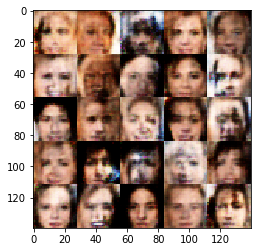

Epoch 1/1... Generator Loss: 1.1054 Discriminator Loss: 1.0701...
Epoch 1/1... Generator Loss: 0.7750 Discriminator Loss: 1.1806...
Epoch 1/1... Generator Loss: 0.8000 Discriminator Loss: 1.1616...
Epoch 1/1... Generator Loss: 1.0139 Discriminator Loss: 0.9987...
Epoch 1/1... Generator Loss: 0.3147 Discriminator Loss: 1.8307...
Epoch 1/1... Generator Loss: 1.3631 Discriminator Loss: 1.1211...
Epoch 1/1... Generator Loss: 1.0885 Discriminator Loss: 1.0571...
Epoch 1/1... Generator Loss: 1.0702 Discriminator Loss: 1.2019...
Epoch 1/1... Generator Loss: 0.7474 Discriminator Loss: 1.1202...
Epoch 1/1... Generator Loss: 0.8247 Discriminator Loss: 1.1435...


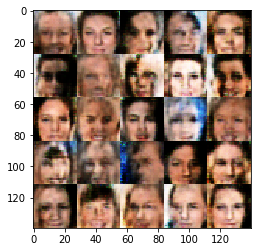

Epoch 1/1... Generator Loss: 2.3051 Discriminator Loss: 1.6823...
Epoch 1/1... Generator Loss: 0.8796 Discriminator Loss: 1.0548...
Epoch 1/1... Generator Loss: 1.0218 Discriminator Loss: 1.0010...
Epoch 1/1... Generator Loss: 0.5612 Discriminator Loss: 1.4747...
Epoch 1/1... Generator Loss: 2.4175 Discriminator Loss: 1.4526...
Epoch 1/1... Generator Loss: 0.6302 Discriminator Loss: 1.2943...
Epoch 1/1... Generator Loss: 0.2436 Discriminator Loss: 2.0151...
Epoch 1/1... Generator Loss: 0.8042 Discriminator Loss: 1.0882...
Epoch 1/1... Generator Loss: 1.2782 Discriminator Loss: 1.0500...
Epoch 1/1... Generator Loss: 0.7066 Discriminator Loss: 1.2048...


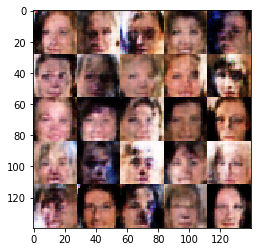

Epoch 1/1... Generator Loss: 1.0536 Discriminator Loss: 1.1116...
Epoch 1/1... Generator Loss: 0.9362 Discriminator Loss: 1.1851...
Epoch 1/1... Generator Loss: 1.0319 Discriminator Loss: 1.2426...
Epoch 1/1... Generator Loss: 1.1718 Discriminator Loss: 1.3867...
Epoch 1/1... Generator Loss: 0.5141 Discriminator Loss: 1.4014...
Epoch 1/1... Generator Loss: 2.2237 Discriminator Loss: 1.7048...
Epoch 1/1... Generator Loss: 1.3387 Discriminator Loss: 1.1183...
Epoch 1/1... Generator Loss: 0.9000 Discriminator Loss: 1.1274...
Epoch 1/1... Generator Loss: 1.1125 Discriminator Loss: 1.1122...
Epoch 1/1... Generator Loss: 1.0060 Discriminator Loss: 1.2116...


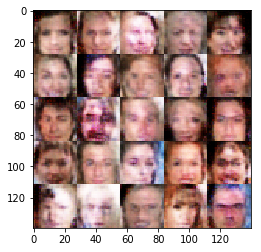

Epoch 1/1... Generator Loss: 1.1086 Discriminator Loss: 1.0776...
Epoch 1/1... Generator Loss: 1.3570 Discriminator Loss: 1.2181...
Epoch 1/1... Generator Loss: 1.6326 Discriminator Loss: 1.4613...
Epoch 1/1... Generator Loss: 2.2706 Discriminator Loss: 1.5316...
Epoch 1/1... Generator Loss: 0.6513 Discriminator Loss: 1.3036...
Epoch 1/1... Generator Loss: 0.9286 Discriminator Loss: 1.2336...
Epoch 1/1... Generator Loss: 1.6361 Discriminator Loss: 1.3983...
Epoch 1/1... Generator Loss: 0.5869 Discriminator Loss: 1.5279...
Epoch 1/1... Generator Loss: 0.9543 Discriminator Loss: 1.1495...
Epoch 1/1... Generator Loss: 0.7198 Discriminator Loss: 1.3197...


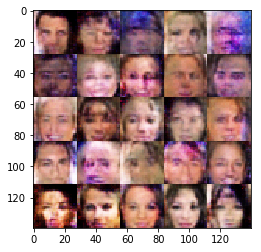

Epoch 1/1... Generator Loss: 1.7618 Discriminator Loss: 1.6374...
Epoch 1/1... Generator Loss: 0.7475 Discriminator Loss: 1.1945...
Epoch 1/1... Generator Loss: 0.4065 Discriminator Loss: 1.5218...
Epoch 1/1... Generator Loss: 0.8922 Discriminator Loss: 1.1571...
Epoch 1/1... Generator Loss: 0.9086 Discriminator Loss: 1.1223...
Epoch 1/1... Generator Loss: 0.7936 Discriminator Loss: 1.2646...
Epoch 1/1... Generator Loss: 0.6869 Discriminator Loss: 1.2075...
Epoch 1/1... Generator Loss: 0.7209 Discriminator Loss: 1.1971...
Epoch 1/1... Generator Loss: 0.9062 Discriminator Loss: 1.2980...
Epoch 1/1... Generator Loss: 1.4143 Discriminator Loss: 1.4039...


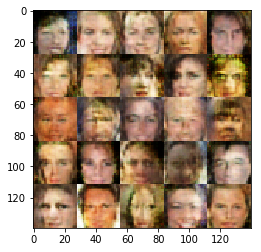

Epoch 1/1... Generator Loss: 0.9452 Discriminator Loss: 1.1114...
Epoch 1/1... Generator Loss: 0.8600 Discriminator Loss: 1.2285...
Epoch 1/1... Generator Loss: 0.9976 Discriminator Loss: 1.2401...
Epoch 1/1... Generator Loss: 0.9967 Discriminator Loss: 1.3404...
Epoch 1/1... Generator Loss: 1.2244 Discriminator Loss: 1.1922...
Epoch 1/1... Generator Loss: 1.1360 Discriminator Loss: 1.1958...
Epoch 1/1... Generator Loss: 0.6535 Discriminator Loss: 1.2378...
Epoch 1/1... Generator Loss: 1.0046 Discriminator Loss: 1.0994...
Epoch 1/1... Generator Loss: 1.0890 Discriminator Loss: 1.2459...
Epoch 1/1... Generator Loss: 0.7196 Discriminator Loss: 1.2399...


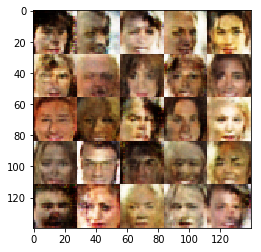

Epoch 1/1... Generator Loss: 0.9317 Discriminator Loss: 1.2092...
Epoch 1/1... Generator Loss: 0.7416 Discriminator Loss: 1.1393...
Epoch 1/1... Generator Loss: 0.9300 Discriminator Loss: 1.2889...
Epoch 1/1... Generator Loss: 1.0524 Discriminator Loss: 1.1115...
Epoch 1/1... Generator Loss: 0.7946 Discriminator Loss: 1.2704...
Epoch 1/1... Generator Loss: 1.3939 Discriminator Loss: 1.0085...
Epoch 1/1... Generator Loss: 1.0917 Discriminator Loss: 1.2489...
Epoch 1/1... Generator Loss: 1.1935 Discriminator Loss: 1.1509...
Epoch 1/1... Generator Loss: 0.8977 Discriminator Loss: 1.2202...
Epoch 1/1... Generator Loss: 0.9633 Discriminator Loss: 1.2001...


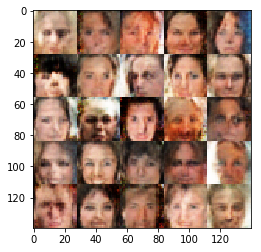

Epoch 1/1... Generator Loss: 0.5393 Discriminator Loss: 1.4098...
Epoch 1/1... Generator Loss: 1.0636 Discriminator Loss: 1.1521...
Epoch 1/1... Generator Loss: 0.6789 Discriminator Loss: 1.3565...
Epoch 1/1... Generator Loss: 0.8740 Discriminator Loss: 1.2740...
Epoch 1/1... Generator Loss: 1.1285 Discriminator Loss: 1.1551...
Epoch 1/1... Generator Loss: 1.1922 Discriminator Loss: 1.2365...
Epoch 1/1... Generator Loss: 0.7563 Discriminator Loss: 1.2691...
Epoch 1/1... Generator Loss: 0.7955 Discriminator Loss: 1.3676...
Epoch 1/1... Generator Loss: 0.9890 Discriminator Loss: 1.7808...
Epoch 1/1... Generator Loss: 1.2799 Discriminator Loss: 1.3829...


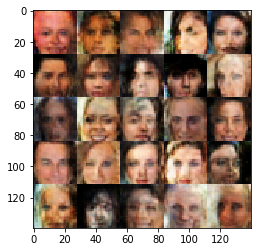

Epoch 1/1... Generator Loss: 1.0255 Discriminator Loss: 1.3395...
Epoch 1/1... Generator Loss: 0.7595 Discriminator Loss: 1.2836...
Epoch 1/1... Generator Loss: 0.8933 Discriminator Loss: 1.2075...
Epoch 1/1... Generator Loss: 0.5695 Discriminator Loss: 1.3680...
Epoch 1/1... Generator Loss: 1.0378 Discriminator Loss: 1.0265...
Epoch 1/1... Generator Loss: 0.4312 Discriminator Loss: 1.5591...
Epoch 1/1... Generator Loss: 0.7157 Discriminator Loss: 1.3502...
Epoch 1/1... Generator Loss: 0.9997 Discriminator Loss: 1.2375...
Epoch 1/1... Generator Loss: 0.8464 Discriminator Loss: 1.2409...
Epoch 1/1... Generator Loss: 0.7857 Discriminator Loss: 1.2814...


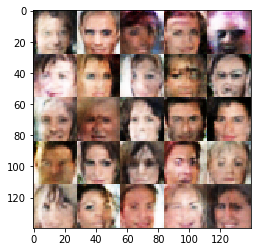

Epoch 1/1... Generator Loss: 0.9247 Discriminator Loss: 1.2055...
Epoch 1/1... Generator Loss: 1.0390 Discriminator Loss: 1.3309...
Epoch 1/1... Generator Loss: 0.9611 Discriminator Loss: 1.3897...
Epoch 1/1... Generator Loss: 0.9052 Discriminator Loss: 1.2617...
Epoch 1/1... Generator Loss: 1.2263 Discriminator Loss: 1.0966...
Epoch 1/1... Generator Loss: 0.4922 Discriminator Loss: 1.5018...
Epoch 1/1... Generator Loss: 0.6034 Discriminator Loss: 1.3190...
Epoch 1/1... Generator Loss: 0.7424 Discriminator Loss: 1.2261...
Epoch 1/1... Generator Loss: 0.6933 Discriminator Loss: 1.4494...
Epoch 1/1... Generator Loss: 1.0070 Discriminator Loss: 1.1559...


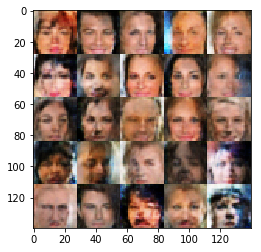

Epoch 1/1... Generator Loss: 0.5931 Discriminator Loss: 1.3046...
Epoch 1/1... Generator Loss: 0.8328 Discriminator Loss: 1.3240...
Epoch 1/1... Generator Loss: 0.8090 Discriminator Loss: 1.2847...
Epoch 1/1... Generator Loss: 1.0244 Discriminator Loss: 1.1947...
Epoch 1/1... Generator Loss: 0.9588 Discriminator Loss: 1.1749...
Epoch 1/1... Generator Loss: 0.9935 Discriminator Loss: 1.3048...
Epoch 1/1... Generator Loss: 0.7050 Discriminator Loss: 1.3671...
Epoch 1/1... Generator Loss: 1.0384 Discriminator Loss: 1.1991...
Epoch 1/1... Generator Loss: 0.7943 Discriminator Loss: 1.2239...
Epoch 1/1... Generator Loss: 0.8784 Discriminator Loss: 1.1707...


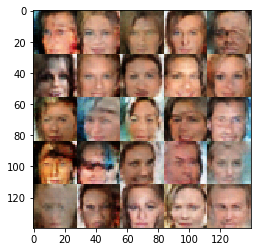

Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.1606...
Epoch 1/1... Generator Loss: 0.5604 Discriminator Loss: 1.4081...
Epoch 1/1... Generator Loss: 0.6374 Discriminator Loss: 1.3170...
Epoch 1/1... Generator Loss: 0.5345 Discriminator Loss: 1.4012...
Epoch 1/1... Generator Loss: 1.0784 Discriminator Loss: 1.3701...
Epoch 1/1... Generator Loss: 0.7291 Discriminator Loss: 1.3163...
Epoch 1/1... Generator Loss: 1.1559 Discriminator Loss: 1.1672...
Epoch 1/1... Generator Loss: 1.2244 Discriminator Loss: 0.9260...
Epoch 1/1... Generator Loss: 0.8719 Discriminator Loss: 1.2266...
Epoch 1/1... Generator Loss: 0.8126 Discriminator Loss: 1.2374...


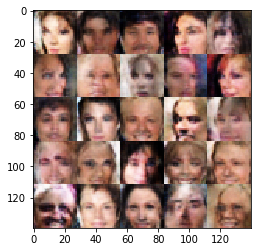

Epoch 1/1... Generator Loss: 0.8616 Discriminator Loss: 1.1894...
Epoch 1/1... Generator Loss: 0.6528 Discriminator Loss: 1.4122...
Epoch 1/1... Generator Loss: 0.8078 Discriminator Loss: 1.2912...
Epoch 1/1... Generator Loss: 0.8353 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.5389 Discriminator Loss: 1.3487...
Epoch 1/1... Generator Loss: 1.0212 Discriminator Loss: 1.2581...
Epoch 1/1... Generator Loss: 0.9682 Discriminator Loss: 1.3532...
Epoch 1/1... Generator Loss: 0.9276 Discriminator Loss: 1.1766...
Epoch 1/1... Generator Loss: 1.2206 Discriminator Loss: 1.2555...
Epoch 1/1... Generator Loss: 0.9667 Discriminator Loss: 1.2265...


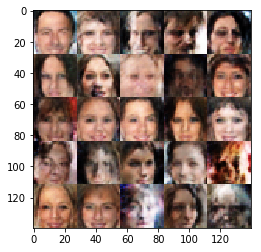

Epoch 1/1... Generator Loss: 1.2891 Discriminator Loss: 1.1630...
Epoch 1/1... Generator Loss: 0.8077 Discriminator Loss: 1.2249...
Epoch 1/1... Generator Loss: 0.7789 Discriminator Loss: 1.3011...
Epoch 1/1... Generator Loss: 0.7840 Discriminator Loss: 1.4399...
Epoch 1/1... Generator Loss: 0.6046 Discriminator Loss: 1.4199...
Epoch 1/1... Generator Loss: 0.5453 Discriminator Loss: 1.4233...
Epoch 1/1... Generator Loss: 1.3838 Discriminator Loss: 1.1685...
Epoch 1/1... Generator Loss: 0.7334 Discriminator Loss: 1.3832...
Epoch 1/1... Generator Loss: 1.0236 Discriminator Loss: 1.1002...
Epoch 1/1... Generator Loss: 0.7468 Discriminator Loss: 1.2848...


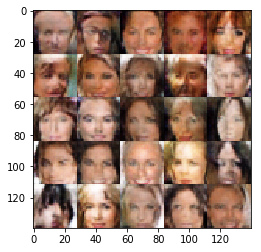

Epoch 1/1... Generator Loss: 0.5860 Discriminator Loss: 1.3851...
Epoch 1/1... Generator Loss: 0.7376 Discriminator Loss: 1.3171...
Epoch 1/1... Generator Loss: 1.1518 Discriminator Loss: 1.2280...
Epoch 1/1... Generator Loss: 0.8173 Discriminator Loss: 1.2579...
Epoch 1/1... Generator Loss: 0.6266 Discriminator Loss: 1.3360...
Epoch 1/1... Generator Loss: 0.9046 Discriminator Loss: 1.1919...
Epoch 1/1... Generator Loss: 0.9049 Discriminator Loss: 1.1410...
Epoch 1/1... Generator Loss: 0.7509 Discriminator Loss: 1.2122...
Epoch 1/1... Generator Loss: 0.8136 Discriminator Loss: 1.2801...
Epoch 1/1... Generator Loss: 0.5378 Discriminator Loss: 1.5287...


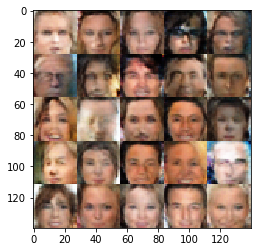

Epoch 1/1... Generator Loss: 0.8776 Discriminator Loss: 1.1484...
Epoch 1/1... Generator Loss: 0.8483 Discriminator Loss: 1.1284...
Epoch 1/1... Generator Loss: 1.4172 Discriminator Loss: 1.3738...
Epoch 1/1... Generator Loss: 0.6724 Discriminator Loss: 1.2868...
Epoch 1/1... Generator Loss: 1.1811 Discriminator Loss: 1.2472...
Epoch 1/1... Generator Loss: 0.8841 Discriminator Loss: 1.3207...
Epoch 1/1... Generator Loss: 1.1984 Discriminator Loss: 1.2627...
Epoch 1/1... Generator Loss: 0.7300 Discriminator Loss: 1.2944...
Epoch 1/1... Generator Loss: 0.6404 Discriminator Loss: 1.2347...
Epoch 1/1... Generator Loss: 1.2294 Discriminator Loss: 1.1829...


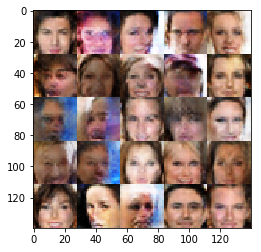

Epoch 1/1... Generator Loss: 0.9530 Discriminator Loss: 1.1948...
Epoch 1/1... Generator Loss: 1.0510 Discriminator Loss: 1.0163...
Epoch 1/1... Generator Loss: 0.6546 Discriminator Loss: 1.2404...
Epoch 1/1... Generator Loss: 0.9690 Discriminator Loss: 1.2164...
Epoch 1/1... Generator Loss: 1.1149 Discriminator Loss: 1.2844...
Epoch 1/1... Generator Loss: 0.9574 Discriminator Loss: 1.3112...
Epoch 1/1... Generator Loss: 0.9262 Discriminator Loss: 1.1277...
Epoch 1/1... Generator Loss: 0.9432 Discriminator Loss: 1.2050...
Epoch 1/1... Generator Loss: 0.7603 Discriminator Loss: 1.3291...
Epoch 1/1... Generator Loss: 0.6904 Discriminator Loss: 1.3385...


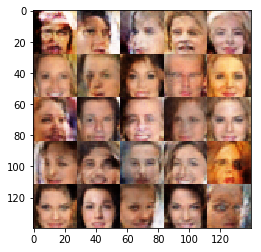

Epoch 1/1... Generator Loss: 0.7710 Discriminator Loss: 1.2351...
Epoch 1/1... Generator Loss: 1.2586 Discriminator Loss: 1.0665...
Epoch 1/1... Generator Loss: 0.6124 Discriminator Loss: 1.4386...
Epoch 1/1... Generator Loss: 0.5340 Discriminator Loss: 1.4544...
Epoch 1/1... Generator Loss: 0.8025 Discriminator Loss: 1.2480...
Epoch 1/1... Generator Loss: 1.0383 Discriminator Loss: 1.2965...
Epoch 1/1... Generator Loss: 1.0465 Discriminator Loss: 1.1277...
Epoch 1/1... Generator Loss: 0.7931 Discriminator Loss: 1.2735...
Epoch 1/1... Generator Loss: 0.8170 Discriminator Loss: 1.3208...
Epoch 1/1... Generator Loss: 0.7526 Discriminator Loss: 1.2567...


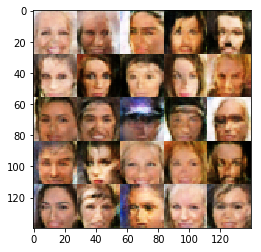

Epoch 1/1... Generator Loss: 0.7012 Discriminator Loss: 1.2396...
Epoch 1/1... Generator Loss: 1.0919 Discriminator Loss: 1.1973...
Epoch 1/1... Generator Loss: 0.7125 Discriminator Loss: 1.3019...
Epoch 1/1... Generator Loss: 0.8195 Discriminator Loss: 1.1746...
Epoch 1/1... Generator Loss: 0.5851 Discriminator Loss: 1.3776...
Epoch 1/1... Generator Loss: 0.8475 Discriminator Loss: 1.1710...
Epoch 1/1... Generator Loss: 0.9947 Discriminator Loss: 1.1408...
Epoch 1/1... Generator Loss: 0.8145 Discriminator Loss: 1.3634...
Epoch 1/1... Generator Loss: 0.7166 Discriminator Loss: 1.3688...
Epoch 1/1... Generator Loss: 0.9099 Discriminator Loss: 1.1888...


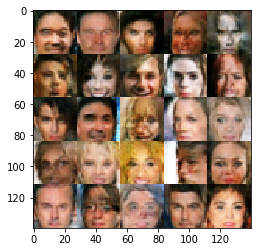

Epoch 1/1... Generator Loss: 0.7108 Discriminator Loss: 1.2940...
Epoch 1/1... Generator Loss: 0.7710 Discriminator Loss: 1.3117...
Epoch 1/1... Generator Loss: 0.9053 Discriminator Loss: 1.2544...
Epoch 1/1... Generator Loss: 0.5757 Discriminator Loss: 1.4508...
Epoch 1/1... Generator Loss: 0.9938 Discriminator Loss: 1.2693...
Epoch 1/1... Generator Loss: 0.5407 Discriminator Loss: 1.3219...
Epoch 1/1... Generator Loss: 0.8089 Discriminator Loss: 1.2796...
Epoch 1/1... Generator Loss: 0.8193 Discriminator Loss: 1.3162...
Epoch 1/1... Generator Loss: 0.9650 Discriminator Loss: 1.2865...
Epoch 1/1... Generator Loss: 1.0079 Discriminator Loss: 1.2773...


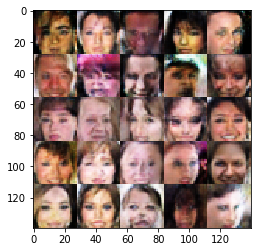

Epoch 1/1... Generator Loss: 0.7414 Discriminator Loss: 1.3253...
Epoch 1/1... Generator Loss: 0.8754 Discriminator Loss: 1.2586...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.2110...
Epoch 1/1... Generator Loss: 1.0696 Discriminator Loss: 1.3313...
Epoch 1/1... Generator Loss: 0.8521 Discriminator Loss: 1.3149...
Epoch 1/1... Generator Loss: 0.6825 Discriminator Loss: 1.3465...
Epoch 1/1... Generator Loss: 0.6093 Discriminator Loss: 1.4001...
Epoch 1/1... Generator Loss: 1.4425 Discriminator Loss: 1.1835...
Epoch 1/1... Generator Loss: 0.7599 Discriminator Loss: 1.2684...
Epoch 1/1... Generator Loss: 0.8847 Discriminator Loss: 1.2705...


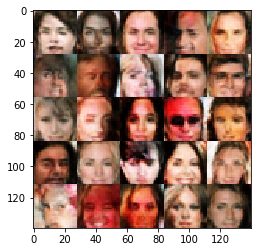

Epoch 1/1... Generator Loss: 0.9633 Discriminator Loss: 1.1815...
Epoch 1/1... Generator Loss: 0.5883 Discriminator Loss: 1.4275...
Epoch 1/1... Generator Loss: 0.9830 Discriminator Loss: 1.2000...
Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.2533...
Epoch 1/1... Generator Loss: 0.9689 Discriminator Loss: 1.0066...
Epoch 1/1... Generator Loss: 0.8160 Discriminator Loss: 1.2112...
Epoch 1/1... Generator Loss: 0.8351 Discriminator Loss: 1.2893...
Epoch 1/1... Generator Loss: 0.6808 Discriminator Loss: 1.3122...
Epoch 1/1... Generator Loss: 1.0911 Discriminator Loss: 1.1606...
Epoch 1/1... Generator Loss: 0.5898 Discriminator Loss: 1.4517...


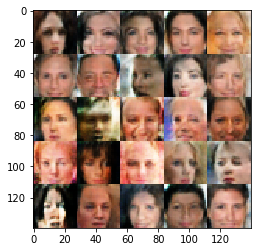

Epoch 1/1... Generator Loss: 0.7711 Discriminator Loss: 1.2506...
Epoch 1/1... Generator Loss: 0.7156 Discriminator Loss: 1.3613...
Epoch 1/1... Generator Loss: 0.7453 Discriminator Loss: 1.3223...
Epoch 1/1... Generator Loss: 0.4590 Discriminator Loss: 1.4671...
Epoch 1/1... Generator Loss: 0.7309 Discriminator Loss: 1.2985...
Epoch 1/1... Generator Loss: 0.8845 Discriminator Loss: 1.2001...
Epoch 1/1... Generator Loss: 1.3040 Discriminator Loss: 1.1983...
Epoch 1/1... Generator Loss: 0.8526 Discriminator Loss: 1.3103...
Epoch 1/1... Generator Loss: 0.9886 Discriminator Loss: 1.1537...
Epoch 1/1... Generator Loss: 0.7195 Discriminator Loss: 1.3151...


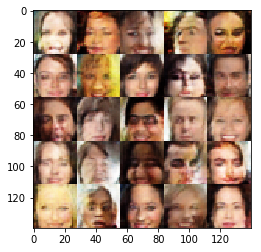

Epoch 1/1... Generator Loss: 0.8110 Discriminator Loss: 1.2471...
Epoch 1/1... Generator Loss: 1.0353 Discriminator Loss: 1.0791...
Epoch 1/1... Generator Loss: 0.8459 Discriminator Loss: 1.2534...
Epoch 1/1... Generator Loss: 0.7471 Discriminator Loss: 1.2915...
Epoch 1/1... Generator Loss: 0.4682 Discriminator Loss: 1.6464...
Epoch 1/1... Generator Loss: 1.2744 Discriminator Loss: 0.9405...
Epoch 1/1... Generator Loss: 0.6219 Discriminator Loss: 1.4252...
Epoch 1/1... Generator Loss: 0.8545 Discriminator Loss: 1.2312...
Epoch 1/1... Generator Loss: 0.6043 Discriminator Loss: 1.4286...
Epoch 1/1... Generator Loss: 0.6174 Discriminator Loss: 1.4892...


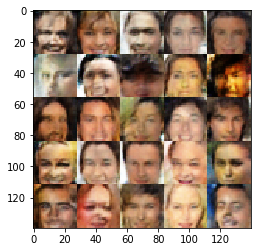

Epoch 1/1... Generator Loss: 0.9692 Discriminator Loss: 1.2081...
Epoch 1/1... Generator Loss: 0.9782 Discriminator Loss: 1.1787...
Epoch 1/1... Generator Loss: 0.7118 Discriminator Loss: 1.2932...
Epoch 1/1... Generator Loss: 0.7920 Discriminator Loss: 1.2572...
Epoch 1/1... Generator Loss: 0.8395 Discriminator Loss: 1.2250...
Epoch 1/1... Generator Loss: 0.9542 Discriminator Loss: 1.2136...
Epoch 1/1... Generator Loss: 1.0394 Discriminator Loss: 1.0382...
Epoch 1/1... Generator Loss: 0.9212 Discriminator Loss: 1.4027...
Epoch 1/1... Generator Loss: 0.7256 Discriminator Loss: 1.3531...
Epoch 1/1... Generator Loss: 0.9970 Discriminator Loss: 1.1569...


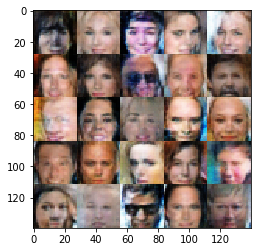

Epoch 1/1... Generator Loss: 0.8435 Discriminator Loss: 1.2485...
Epoch 1/1... Generator Loss: 0.5924 Discriminator Loss: 1.4579...
Epoch 1/1... Generator Loss: 0.5482 Discriminator Loss: 1.4357...
Epoch 1/1... Generator Loss: 0.7078 Discriminator Loss: 1.2452...
Epoch 1/1... Generator Loss: 0.9309 Discriminator Loss: 1.1273...
Epoch 1/1... Generator Loss: 1.1338 Discriminator Loss: 1.1691...
Epoch 1/1... Generator Loss: 1.0533 Discriminator Loss: 1.3254...
Epoch 1/1... Generator Loss: 0.8997 Discriminator Loss: 1.1808...
Epoch 1/1... Generator Loss: 0.6396 Discriminator Loss: 1.4732...
Epoch 1/1... Generator Loss: 0.8708 Discriminator Loss: 1.2721...


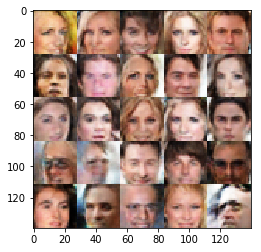

Epoch 1/1... Generator Loss: 1.1950 Discriminator Loss: 1.1659...
Epoch 1/1... Generator Loss: 0.9144 Discriminator Loss: 1.1726...
Epoch 1/1... Generator Loss: 0.7568 Discriminator Loss: 1.3433...
Epoch 1/1... Generator Loss: 0.9965 Discriminator Loss: 1.3068...
Epoch 1/1... Generator Loss: 0.8254 Discriminator Loss: 1.2131...
Epoch 1/1... Generator Loss: 0.8062 Discriminator Loss: 1.3163...


In [23]:
batch_size = 64
z_dim = 100
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.